In [1]:
import numpy as np

MatMulの逆伝播（毎回同じWhが使われる）

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


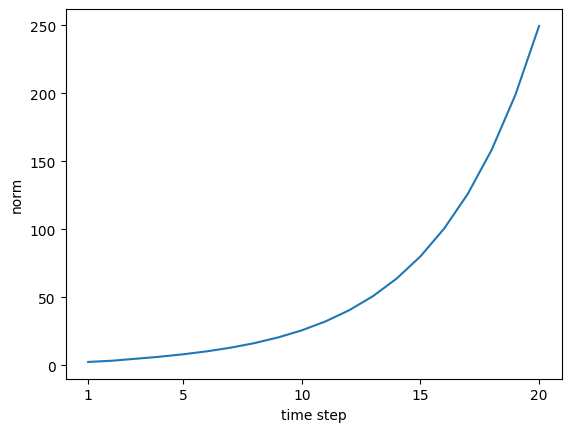

In [2]:
# coding: utf-8
import matplotlib.pyplot as plt

N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H) # 勾配爆発の再現（大きさ１より大きい行列をT回乗算）
#Wh = np.random.randn(H, H) * 0.5 # 勾配消失の再現（大きさ１より小さい行列をT回乗算）

norm_list = []
# 時系列の長さだけ逆伝播
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # 行列の大きさをはかるためL2ノルム
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()


クリッピング（勾配爆発防止）

In [3]:
# パラメータの勾配を一つにまとめたgradsのノルムがmax_normより大きい時、まとめて勾配を小さくする
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm) # 勾配全体のノルム

    # 勾配全体のノルムがmax_normより大きいか
    rate = max_norm / (total_norm + 1e-6) # 大きければkrateが１未満になる（0.8とか）
    if rate < 1:
        for grad in grads:
            grad *= rate # 勾配全体のノルムに対するmax_normの比率(rate)をそのまま各勾配に乗算して小さくする


In [4]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


LSTM(Long Short-Term Memory)実装

In [5]:
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.functions import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        """

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        """
        self.params = [Wx, Wh, b] # ４種類(f,g,i,o)のWx,Wh,bが格納されている
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 同様に４種類ずつの形状の勾配を初期化
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        # 4つ分の重みをまとめてAffine変換する
        # A(N, 4H) = xt(N,D)Wx(D,4H) + h_prev(N,H)Wh(H,4H) + b(4H,)
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        # A (N, 4H)
        # +--------+--------+--------+--------+
        # | f1, f2, f3, ..., fH | g1, g2, g3, ..., gH | i1, i2, i3, ..., iH | o1, o2, o3, ..., oH |
        # | f1, f2, f3, ..., fH | g1, g2, g3, ..., gH | i1, i2, i3, ..., iH | o1, o2, o3, ..., oH |
        # | f1, f2, f3, ..., fH | g1, g2, g3, ..., gH | i1, i2, i3, ..., iH | o1, o2, o3, ..., oH |
        # N行続く
        #+----------------------------------+

        # スライス
        f = A[:, : H]
        # e.g.+--------+
        # | f1, f2, fH|
        # +--------+
        # | f1, f2, fH|
        # +--------+
        # | f1, f2, fH|
        # +--------+
        g = A[:, H : 2 * H]
        i = A[:, 2 * H : 3 * H]
        o = A[:, 3 * H :]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next**2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= 1 - g**2

        # 水平につなげていく（前伝播のA(N, 4H)と同じ形状にする）
        dA = np.hstack((df, dg, di, do))
        # dA (N, 4H)
        # +-----------------------------------------+
        # | df1, df2, df3, ..., dfH, dg1, dg2, dg3, ..., dgH, di1, di2, di3, ..., diH, do1, do2, do3, ..., doH |
        # +-----------------------------------------+
        # | df1, df2, df3, ..., dfH, dg1, dg2, dg3, ..., dgH, di1, di2, di3, ..., diH, do1, do2, do3, ..., doH |

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

In [6]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b] # ４種類(f,g,i,o)のWx,Wh,bが格納されている
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 同様に４種類ずつの形状で勾配を初期化
        self.layers = None

        self.h, self.c = None, None # ブロック間の引き継ぎのためメンバ変数に
        self.dh = None # ブロック間の引き継ぎのためメンバ変数に
        self.stateful = stateful

    # 入力xs(分散表現)に対しLSTMレイヤを時系列の長さだけ生成して各々計算
    def forward(self, xs):
        # 下でhs, self.h, self.cの初期化をする時の形状に使うため重みパラメータを呼んで形状(N,T,H)取得
        Wx, Wh, b = self.params # LSTM内で使用
        N, T, D = xs.shape # Wx(D, 4H)
        H = Wh.shape[0] #Wh(H, 4H)

        self.layers = []
        # hs = h_prev*Wh + x*Wx + b(N,T,H)が４種類あり色々計算するが.
        # その計算は要素ごとの乗算や正規化,加算だけで形状は一つのh_prev*Wh + x*Wx + bの計算後と同じ(N,T,H)
        hs = np.empty((N, T, H), dtype="f") # 単にhを追加するだけだからメモリ確保だけでいい

        # 隠れ状態にしない設定または初回LSTM呼び出し時はself.hとself.cがNoneだからゼロ行列に初期化
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype="f")
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype="f")

        for t in range(T):
            layer = LSTM(*self.params)
            #次の時刻に使う隠れ状態（短期記憶と出力）と記憶セル（長期記憶）をメンバ変数にする
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        # 下でdxsの初期化をする時の形状に使うため重みパラメータを呼んで形状(N,T,D)取得
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0] # Wx(D, H)

        dxs = np.empty((N, T, D), dtype="f")
        dh, dc = 0, 0 # 一番最初の計算では０で更新され前時刻に渡される

        grads = [0, 0, 0] # dWx, dWh, db
        for t in reversed(range(T)):
            layer = self.layers[t]
            # 前伝播の時はhを複製(repeat)して出力側とt+1に渡し、逆伝播の時はそれぞれの勾配の合計を求める
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad # LSTMでの対応する勾配同士（dWx, dWh, db）を合計することでモデル全体の最適化をする

        for i, grad in enumerate(grads): # 合計されたi番目の重み勾配(dWx,dWh,db)
            self.grads[i][...] = grad # メンバ変数にそれぞれの要素をコピー
        self.dh = dh # ７章で扱う(Sequence to Sequence)

        return dxs # 前レイヤ（Embeddingレイヤ）に渡す

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

言語モデル実装

In [7]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel): # BaseModelクラスからsave_params(), load_params()を利用、またGPU対応やビット削減も担う
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size # D: 分散表現、H: 隠れ層のユニット数（モデルが一度に保持できる情報の量）
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


学習コードとテスト

| epoch 1 |  iter 20 / 1327 | time 2[s] | perplexity 3287.03
| epoch 1 |  iter 40 / 1327 | time 4[s] | perplexity 1253.32
| epoch 1 |  iter 60 / 1327 | time 7[s] | perplexity 991.64
| epoch 1 |  iter 80 / 1327 | time 10[s] | perplexity 820.71
| epoch 1 |  iter 100 / 1327 | time 12[s] | perplexity 639.07
| epoch 1 |  iter 120 / 1327 | time 15[s] | perplexity 633.62
| epoch 1 |  iter 140 / 1327 | time 18[s] | perplexity 607.36
| epoch 1 |  iter 160 / 1327 | time 20[s] | perplexity 566.64
| epoch 1 |  iter 180 / 1327 | time 23[s] | perplexity 566.51
| epoch 1 |  iter 200 / 1327 | time 25[s] | perplexity 519.49
| epoch 1 |  iter 220 / 1327 | time 28[s] | perplexity 491.97
| epoch 1 |  iter 240 / 1327 | time 30[s] | perplexity 457.99
| epoch 1 |  iter 260 / 1327 | time 33[s] | perplexity 478.51
| epoch 1 |  iter 280 / 1327 | time 35[s] | perplexity 459.99
| epoch 1 |  iter 300 / 1327 | time 38[s] | perplexity 392.95
| epoch 1 |  iter 320 / 1327 | time 40[s] | perplexity 358.62
| epoch 1 |  

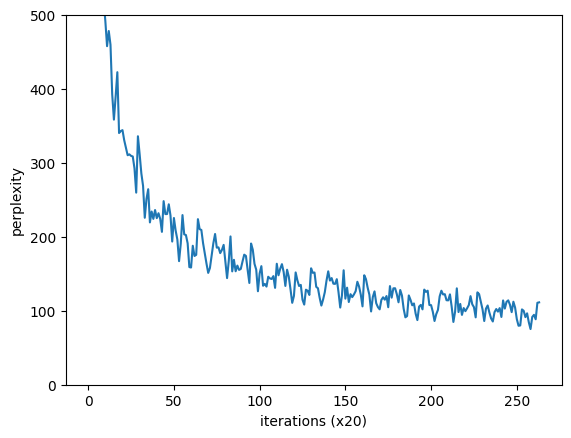

evaluating perplexity ...
234 / 235
test perplexity:  136.30597981323126


In [8]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, # max_gradが勾配クリッピングを適用する
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state() # モデルの状態（LSTMの隠れ状態と記憶セル）をリセット
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()


改良型モデルRNNLM(多層化、ドロップアウト使用、重み共有)

In [9]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 改善点(多層化、ドロップアウト使用、重み共有)
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


改良型モデルRNNLMでの学習（エポック毎に検証データでパープレキシティを評価し、値が悪くなった場合に学習係数下げる）

In [1]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
config.GPU = True # GPUでも数時間かかる！
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)


------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------

| epoch 1 |  iter 20 / 1327 | time 7[s] | perplexity 4252.51
| epoch 1 |  iter 40 / 1327 | time 10[s] | perplexity 1966.11
| epoch 1 |  iter 60 / 1327 | time 13[s] | perplexity 1315.32
| epoch 1 |  iter 80 / 1327 | time 15[s] | perplexity 1066.99
| epoch 1 |  iter 100 / 1327 | time 18[s] | perplexity 832.13
| epoch 1 |  iter 120 / 1327 | time 21[s] | perplexity 792.40
| epoch 1 |  iter 140 / 1327 | time 23[s] | perplexity 723.82
| epoch 1 |  iter 160 / 1327 | time 26[s] | perplexity 706.96
| epoch 1 |  iter 180 / 1327 | time 29[s] | perplexity 689.61
| epoch 1 |  iter 200 / 1327 | time 31[s] | perplexity 586.72
| epoch 1 |  iter 220 / 1327 | time 34[s] | perplexity 569.59
| epoch 1 |  iter 240 / 1327 | time 37[s] | perplexity 534.80
| epoch 1 |  iter 260 / 1327 | time 40[s] | perplexity 535.09
| epoch 1 |  iter 280 / 1327 | ti

In [1]:
# coding: utf-8
import sys
sys.path.append(r'C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
config.GPU = True # GPUでも数時間かかる！
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
train_perplexity_list = []  # 学習データのパープレキシティを保存するリスト
val_perplexity_list = []    # 検証データのパープレキシティを保存するリスト
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)
    ppl_train_perEpoch = trainer.ppl_perEpoch
    train_perplexity_list.append(ppl_train_perEpoch)


    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)
    val_perplexity_list.append(ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# 学習データと検証データのパープレキシティ推移をプロット
plt.plot(range(1, max_epoch + 1), train_perplexity_list, marker='o', label='Train')
plt.plot(range(1, max_epoch + 1), val_perplexity_list, marker='o', linestyle='--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Train and Validation Perplexity per Epoch')
plt.legend()
plt.grid(True)
plt.show()


------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------

| epoch 1 |  iter 20 / 1327 | time 3[s] | perplexity 4758.90
| epoch 1 |  iter 40 / 1327 | time 5[s] | perplexity 1947.11
| epoch 1 |  iter 60 / 1327 | time 8[s] | perplexity 1475.87
| epoch 1 |  iter 80 / 1327 | time 11[s] | perplexity 1038.19
| epoch 1 |  iter 100 / 1327 | time 13[s] | perplexity 848.78
| epoch 1 |  iter 120 / 1327 | time 16[s] | perplexity 800.08
| epoch 1 |  iter 140 / 1327 | time 18[s] | perplexity 733.37
| epoch 1 |  iter 160 / 1327 | time 21[s] | perplexity 689.86
| epoch 1 |  iter 180 / 1327 | time 23[s] | perplexity 656.35
| epoch 1 |  iter 200 / 1327 | time 26[s] | perplexity 614.16
| epoch 1 |  iter 220 / 1327 | time 29[s] | perplexity 570.92
| epoch 1 |  iter 240 / 1327 | time 31[s] | perplexity 519.29


KeyboardInterrupt: 